# A notebook for computing the along-line average for the PIPS dataset from IOP2-2022

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as ptime
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as feature
# from natsort import natsorted
from pprint import pprint
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# print(matplotlib.style.available)

matplotlib.style.use('seaborn-v0_8-bright')

def comp_plot(PIPS_names, ds_dict, varname='fasttemp', alpha=1.0, mask_below=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for PIPS_name in PIPS_names:
        plotvar = ds_dict[PIPS_name][varname]
        if mask_below is not None:
            plotvar = plotvar.where(plotvar > mask_below)
        plotvar.plot(ax=ax, label=PIPS_name, alpha=alpha)
    ax.legend(loc='best')
    return fig, ax

def comp_var_plot(ds, varnames=['pcount', 'pcount_derived'], alpha=1.0, mask_below=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for varname in varnames:
        plotvar = ds[varname]
        if mask_below is not None:
            plotvar = plotvar.where(plotvar > mask_below)
        plotvar.plot(ax=ax, label=varname, alpha=alpha)
    ax.legend(loc='best')
    return fig, ax

In [4]:
# date = '052516' # '053122' # '030622' # '061416'

PIPS_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf"
deployment_name = "IOP2_033022"

PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
parsivel_interval = 10
parsivel_filenames = ['parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
                      for PIPS_name in PIPS_names]
parsivel_filepaths = [os.path.join(PIPS_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]
conv_filenames = ['conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name) for PIPS_name in PIPS_names]
conv_filepaths = [os.path.join(PIPS_dir, conv_filename) for conv_filename in conv_filenames]
parsivel_ds_read_dict = {}
conv_ds_read_dict = {}
for PIPS_name, parsivel_filepath, conv_filepath in zip(PIPS_names, parsivel_filepaths, conv_filepaths):
    parsivel_ds_read_dict[PIPS_name] = xr.load_dataset(parsivel_filepath)
    conv_ds_read_dict[PIPS_name] = xr.load_dataset(conv_filepath)

In [5]:
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_read_dict[PIPS_name]
    print(parsivel_ds['time'][0], parsivel_ds['time'][-1])

<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:49:43.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:49:43
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:25:23.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:25:23
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:41:53.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:41:53
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:33:03.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:33:03
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:59:03.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:59:03
    flagged_times  int64 

In [9]:
# Restrict to certain time range
# start_time = '2022-05-31T23:00' # '2022-03-07T00:00'
# end_time = '2022-06-01T00:05' # '2022-03-08T00:00'
# start_time = '2022-03-30T23:40'
# end_time = '2022-03-31T01:30'
# start_time = '2023-03-12T00:15'
# end_time = '2023-03-12T14:00'
# start_time = '2023-02-22T16:00'
# end_time = '2023-02-23T01:00'
start_time = '2023-03-16T17:45'
end_time = '2023-03-17T15:05'

if False:
    parsivel_ds_dict = {}
    conv_ds_dict = {}
    for PIPS_name in PIPS_names:
        parsivel_ds_dict[PIPS_name] = parsivel_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
        conv_ds_dict[PIPS_name] = conv_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
else:
    parsivel_ds_dict = parsivel_ds_read_dict
    conv_ds_dict = conv_ds_read_dict

In [10]:
parsivel_ds_dict['PIPS1B']

<xarray.Dataset> Size: 18MB
Dimensions:                    (time: 668, fallspeed_bin: 32, diameter_bin: 32,
                                fields_KGWX: 19, parameter: 3)
Coordinates:
  * time                       (time) datetime64[ns] 5kB 2022-03-30T23:41:53 ...
    fallspeed                  (fallspeed_bin) float64 256B 0.05 0.15 ... 20.8
    diameter                   (diameter_bin) float64 256B 0.0625 ... 24.5
    min_diameter               (diameter_bin) float64 256B 0.0 0.125 ... 23.0
    max_diameter               (diameter_bin) float64 256B 0.125 0.25 ... 26.0
    min_fallspeeds             (fallspeed_bin) float64 256B 0.0 0.1 ... 19.2
    max_fallspeeds             (fallspeed_bin) float64 256B 0.1 0.2 ... 22.4
    flagged_times              (time) int64 5kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
  * fields_KGWX                (fields_KGWX) <U12 912B 'REF' ... 'sigma_Z01'
  * parameter                  (parameter) <U5 60B 'N0' 'lamda' 'alpha'
Dimensions without coordinates: fallspeed_bin, diameter_bin
Data variables: (12/73)
    precipintensity            (time) float64 5kB 0.0 2.334 2.51 ... 3.217 3.674
    precipaccum                (time) float64 5kB 0.0 0.0 0.01 ... 37.47 37.48
    parsivel_dBZ               (time) float64 5kB -9.999 30.69 ... 27.51 29.07
    sample_interval            (time) timedelta64[ns] 5kB 00:00:05 ... 00:00:10
    signal_amplitude           (time) float64 5kB 1.986e+04 ... 1.688e+04
    pcount                     (time) int64 5kB 0 38 27 38 ... 127 127 115 128
    ...                         ...
    DSD_MM234_roqc             (parameter, time) float64 16kB nan ... 7.637
    DSD_TMM234_roqc            (parameter, time) float64 16kB nan ... 7.637
    DSD_MM246_roqc             (parameter, time) float64 16kB nan ... 6.767
    DSD_TMM246_roqc            (parameter, time) float64 16kB nan ... 6.767
    DSD_MM346_roqc             (parameter, time) float64 16kB nan ... 6.437
    DSD_TMM346_roqc            (parameter, time) float64 16kB nan ... 3.427
Attributes: (12/18)
    nominal sample interval:  10 seconds
    probe_name:               PIPS1B
    parsivel_angle:           45.0
    deployment_name:          IOP2_033022
    location:                 (33.715000000000025, -88.4505, 66.61888437828897)
    starting_time:            20220330234153
    ...                       ...
    rainonlyQC:               1
    hailonlyQC:               0
    graupelonlyQC:            0
    basicQC:                  0
    retrieval_wavelength:     10.7
    CG_coeff_Z01:             [-1.957  1.213 -0.016]

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='time', ylabel='voltage [volts]'>)

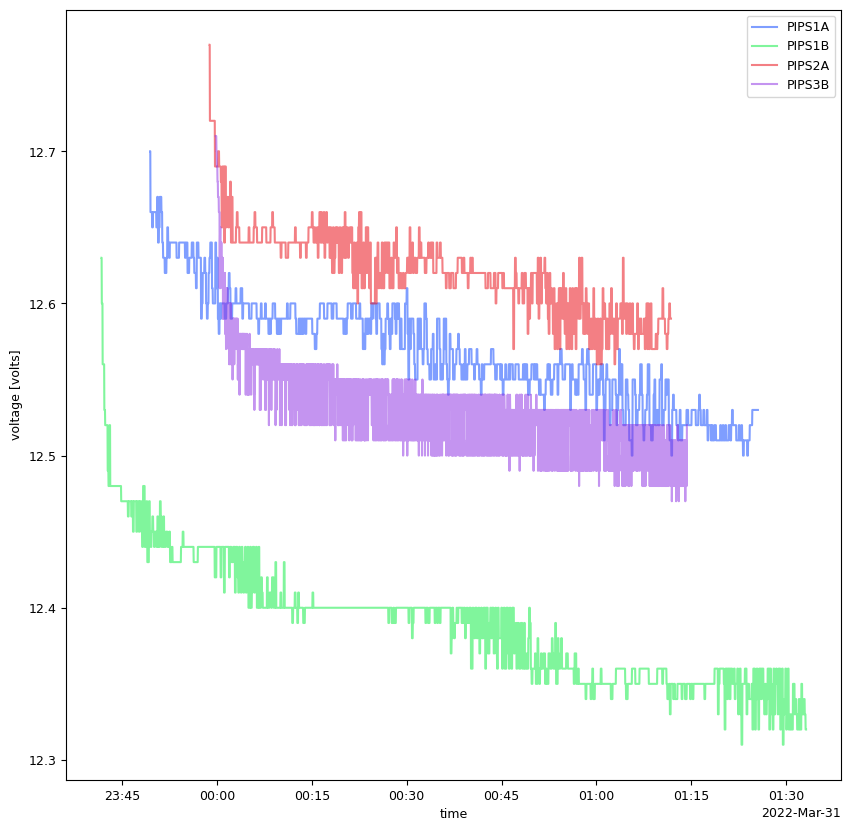

In [11]:
# Plot some diagnostic quantities
comp_plot(PIPS_names, conv_ds_dict, 'voltage', alpha=0.5)

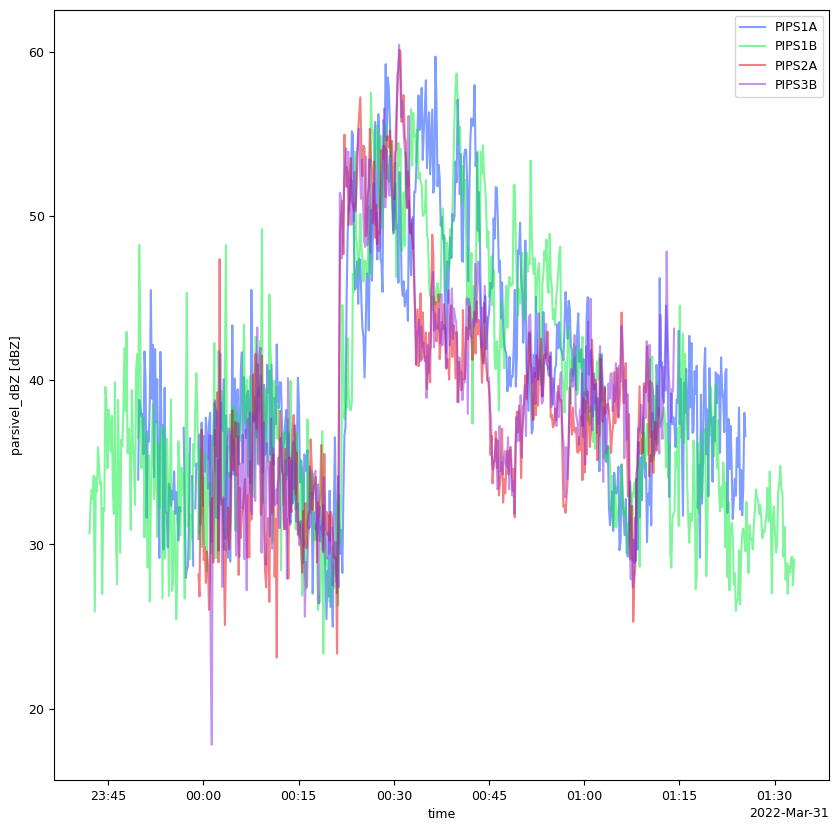

In [12]:
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'parsivel_dBZ', alpha=0.5, mask_below=-9.999)

In [ ]:
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'signal_amplitude', alpha=0.5)

In [ ]:
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'pvoltage', alpha=0.5)

In [ ]:
fig, ax = comp_plot(['PIPS1B', 'PIPS2A'], parsivel_ds_dict, 'precipintensity', alpha=0.5, mask_below=0.)
ax.set_ylim(0., 5.)
ax.set_aspect(0.05)

In [ ]:
fig, ax = comp_plot(['PIPS1A', 'PIPS2A'], parsivel_ds_dict, 'pcount', alpha=0.5, mask_below=0)

In [ ]:
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'sensor_temp', alpha=0.5)

In [ ]:
parsivel_ds = parsivel_ds_dict['PIPS2A']
fig, ax = comp_var_plot(parsivel_ds, varnames=['pcount', 'pcount_derived'], alpha=0.5)

In [ ]:
bottom = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
top = [0, 1, 4, 7, 9, 11, 12, 13, 14, 14, 15, 16, 16, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
splashingmask = [[True if bottom[j] <= i <= top[j]
                  else False for i in range(32)] for j in range(32)]
splashingmask = np.array(splashingmask).T

# splashingmask = np.ma.masked_where(splashingmask, ~splashingmask)

print(splashingmask)
fig, ax = plt.subplots(figsize=(10, 10))
diameter_bin_edges = pp.parsivel_parameters['diameter_bin_edges_mm']
fallspeed_bin_edges = pp.parsivel_parameters['fallspeed_bin_edges_mps']

C = ax.pcolormesh(diameter_bin_edges, fallspeed_bin_edges, splashingmask, edgecolors='w')

ax.set_xlim(0., 9.)
ax.set_ylim(0., 15.)

In [ ]:
parsivel_ds = parsivel_ds_dict['PIPS1B']
vd_matrix = parsivel_ds['VD_matrix'].copy()
vd_matrix_full = vd_matrix.sum(dim='time')
vd_matrix_full = vd_matrix_full.where(vd_matrix_full > 0)
vd_matrix_full.plot()

In [ ]:
vd_matrix_marginqc = pqc.marginQC(parsivel_ds['VD_matrix'].copy())
vd_matrix_marginqc_full = vd_matrix_marginqc.sum(dim='time')
vd_matrix_marginqc_full = vd_matrix_marginqc_full.where(vd_matrix_marginqc_full > 0)
vd_matrix_marginqc_full.plot()

In [ ]:
vd_matrix_splashingqc = pqc.splashingQC(parsivel_ds['VD_matrix'].copy())
vd_matrix_splashingqc_full = vd_matrix_splashingqc.sum(dim='time')
vd_matrix_splashingqc_full = vd_matrix_splashingqc_full.where(vd_matrix_splashingqc_full > 0)
vd_matrix_splashingqc_full.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_dict[PIPS_name]
    wind_dir = parsivel_ds['winddirabs']
    compass_dir = parsivel_ds['compass_dir']
    parsivel_angle = pips.calc_parsivel_wind_angle(wind_dir, compass_dir, parsivel_ds.parsivel_angle)
    parsivel_angle.plot(ax=ax, label=PIPS_name, alpha=0.5)
ax.legend(loc='best')

In [ ]:
conv_ds = conv_ds_dict['PIPS1B']
GPS_spd = conv_ds['GPS_spd']
GPS_rolling = GPS_spd.rolling(time=300)
GPS_rolling_mean = GPS_rolling.mean()
GPS_rolling_mean.plot()

In [ ]:
conv_ds_dict['PIPS1A']

In [ ]:
conv_ds_dict['PIPS1B']

In [ ]:
# Try to use OpenStreetMap for images. Taken from 
# https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

In [ ]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [ ]:
# cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
# osm_img = cimgt.OSM() # spoofed, downloaded street map
cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

In [ ]:
conv_ds = conv_ds_dict['PIPS1A']

fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
location = eval(str(conv_ds.location))
ctrlat = location[0]
ctrlon = location[1]
center_pt = [ctrlat, ctrlon]
zoom = 0.1 # for zooming out of center point
extent = [center_pt[1]-(zoom*2.0),center_pt[1]+(zoom*2.0),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
print(scale)
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
# NOTE: zoom specifications should be selected based on extent:
# -- 2     = coarse image, select for worldwide or continental scales
# -- 4-6   = medium coarseness, select for countries and larger states
# -- 6-10  = medium fineness, select for smaller states, regions, and cities
# -- 10-12 = fine image, select for city boundaries and zip codes
# -- 14+   = extremely fine image, select for roads, blocks, buildings
for PIPS_name, conv_ds in conv_ds_dict.items():
    lons = conv_ds['GPS_lon']
    lons = lons.where(conv_ds['GPS_status'] == 'A', drop=True)
    lats = conv_ds['GPS_lat']
    lats = lats.where(conv_ds['GPS_status'] == 'A', drop=True)
    times = conv_ds['time']
    times = times.where(conv_ds['GPS_status'] == 'A', drop=True)
    sc = ax1.scatter(lons, lats, c=times, marker='o', facecolor='none', alpha=1, transform=ccrs.PlateCarree())

fig.colorbar(sc, ax=ax1)
plt.show() # show the plot

In [ ]:
# Old cells below. Check if there is anything important there and then get rid of them

In [ ]:
# Set up map
width_x = 500. # m
width_y = 500. # m

location = eval(str(conv_ds.location))
ctrlat = location[0]
ctrlon = location[1]

trulon = ctrlon
trulat1 = 35.
trulat2 = 45.
projection = ccrs.LambertConformal(ctrlon, ctrlat, false_easting=width_x/2., false_northing=width_y/2.,
                                   standard_parallels=[trulat1, trulat2])

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# ax.stock_img()
# Add coastlines and states
ax.coastlines()
land = feature.LAND
ax.add_feature(land) # , edgecolor='face', facecolor=feature.COLORS['land'])
states = feature.STATES
# states = feature.NaturalEarthFeature(category="cultural", scale="50m",
#                                      facecolor="none",
#                                      name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=1., edgecolor='k', alpha=0.5)
rivers = feature.RIVERS
ax.add_feature(rivers, linewidth=0.75, edgecolor='b', alpha=0.5)
ax.add_feature(feature.NaturalEarthFeature('cultural', 'roads', '10m'), facecolor='none', edgecolor='b')
# # Add counties if desired. TODO: add back more features here after testing

# # if runname == pc.runname_list[0] and time == time_list[0]:

# print("Reading counties from shapefile")
county_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/county/countyp020'
counties = plotmod.read_shapefile(county_shapefile_location)
ax.add_feature(counties, linewidth=0.5, edgecolor='grey', alpha=0.5)

# Add urban areas
# urban_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/urban2/tl_2008_us_cbsa'
# urban = plotmod.read_shapefile(urban_shapefile_location)
# ax.add_feature(urban, linewidth=0.5, facecolor='purple', edgecolor='none', alpha=0.25)

# Add more stuff from GADM database (EDIT: doesn't seem to add anything beyond counties)
# gadm_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/gadm/gadm36_USA_2'
# gadm_shapes = plotmod.read_shapefile(gadm_shapefile_location)
# ax.add_feature(gadm_shapes, linewidth=0.5, edgecolor='purple', alpha=0.8)

ax.set_xlim(0., width_x)
ax.set_ylim(0., width_y)
# ax.scatter([ctrlon], [ctrlat], color='black', marker='o', facecolor='none', transform=ccrs.PlateCarree())

lons = conv_ds['GPS_lon']
lats = conv_ds['GPS_lat']
ax.scatter(lons, lats, color='black', marker='o', facecolor='none', alpha=0.75, transform=ccrs.PlateCarree())

In [ ]:
print(wind_dir_conv.coords['time'])
print(len(wind_dir_conv.time))
print(len(np.unique(wind_dir_conv.time.data)))
unique_times = np.unique(wind_dir_conv['time'])
print(unique_times)
duplicated = wind_dir_conv.indexes['time'].duplicated()
print(duplicated)
dup_indices = np.where(duplicated)[0]
print(dup_indices)
#duplicated = xr.DataArray(parsivel_ds_read.indexes['time'].duplicated())
duplicated_times = wind_dir_conv['time'].isel(time=dup_indices)
print(duplicated_times)
duplicated_times_only = wind_dir_conv.isel(time=dup_indices)
print(duplicated_times_only)

In [ ]:
time_diff = wind_spd_conv['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
int_indices = range(wind_spd_conv.sizes['time'])
print(wind_spd_conv.coords['time'].values)
int_ind_da = xr.DataArray(int_indices, coords=[('time', wind_spd_conv.coords['time'].values)])
print(int_ind_da)

In [ ]:
print(int_ind_da.sel(time='2017-04-30T20:40:18.000000000'))

In [ ]:
print(wind_spd_conv.isel(time=74415))
print(wind_spd_conv.isel(time=74416))
print(wind_spd_conv.isel(time=74417))
print(wind_spd_conv.isel(time=74418))

In [ ]:
time_diff = parsivel_ds['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
PIPS_dir2 = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_new_test/'
parsivel_filepath2 = os.path.join(PIPS_dir, 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc')
conv_filepath2 = os.path.join(PIPS_dir, 'conventional_raw_FMCW_2017_043017_PIPS2A.nc')
parsivel_ds2 = xr.load_dataset(parsivel_filepath2)
conv_ds2 = xr.load_dataset(conv_filepath2)

In [ ]:
time_diff = parsivel_ds2['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)